In [2]:
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Column
from astroquery.mast import Tesscut
from lightkurve import TessTargetPixelFile, search_targetpixelfile, search_tesscut, TessLightCurve, TessLightCurveFile
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from random import randint

## Prepare data & make star groups

In [3]:
# Import target list
targets = ascii.read("../Tables/cluster_targets_tic.csv")

# Get individual coords
coords = SkyCoord(targets['RAJ2000'], targets['DecJ2000'], unit='deg')

# Group up stars by their magnitude: e.g. if star's mag is b/t 10 and 11, then group up as a 10-mag star.
mags = np.arange(10, 20)
groups = np.zeros(len(targets), dtype=int)

for mag in mags:
    idx = (mag <= targets['G']) & (targets['G'] < mag+1)
    groups[idx] = mag

In [4]:
# Display targets in group 10-mag and show their TIC ID
current_group = 10

# Make list of apertures for current group
apertures = []

# Display targets in group
targets[groups == current_group]['TIC ID']

93267406
93268140
144997798
93912319
144996772
94107183
93268096


In [8]:
targets[groups == current_group]['TIC ID'][0] == 93267406

True

## Prepare sample files for interaction and mask extraction

In [9]:
n_stars = len(targets[groups == current_group])
idxs = np.random.randint(0, n_stars, size=3)
sample_filename = 'SampleTPFs/TESS_{0}_SEC{1}.fits'
lc_filename = '../LightCurves/TESS_LC_{0}_SEC{1}.fits'
sector = 8
cutoutsize = 8
ticids = targets[groups == current_group][idxs]['TIC ID']
ticids

93268140
94107183
93912319


### Start with first sample

In [11]:
tpf = search_tesscut(ticids[0], sector=sector).download(cutout_size=cutoutsize)
tpf.interact(exported_filename=sample_filename.format(ticids[0], sector))
tpf

TessTargetPixelFile(TICID: 93268140)

array([[1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 3, 3, 3, 1, 1],
       [1, 1, 1, 3, 3, 3, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

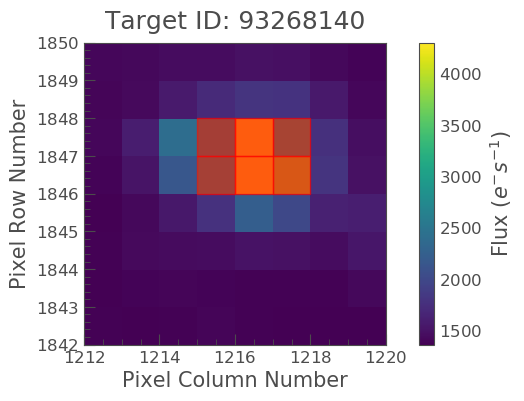

In [15]:
# Open saved LightCurve FITS file, and load the aperture mask
mask_filepath = glob(sample_filename.format(ticids[0], sector))[0]
lcf = TessLightCurveFile(mask_filepath)
current_aperture = lcf.hdu[2].data

# Append current aperture to list of apertures, ONLY if it doesn't exist there already
apertures.append(current_aperture)

# Display current aperture
tpf.plot(aperture_mask=current_aperture, mask_color='red')
current_aperture

### Start with second sample

In [16]:
tpf = search_tesscut(ticids[1], sector=sector).download(cutout_size=cutoutsize)
tpf.interact(exported_filename=sample_filename.format(ticids[1], sector))
tpf

TessTargetPixelFile(TICID: 94107183)

array([[1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 3, 3, 1, 1],
       [1, 1, 1, 3, 3, 3, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

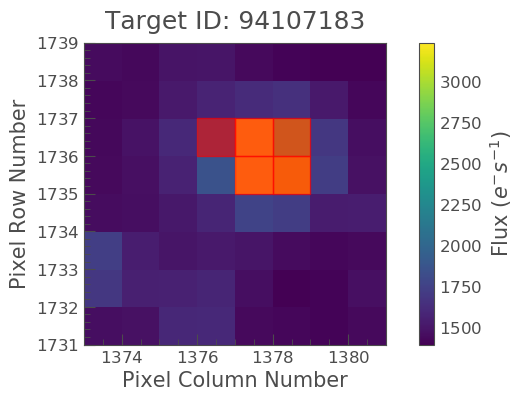

In [18]:
# Open saved LightCurve FITS file, and load the aperture mask
mask_filepath = glob(sample_filename.format(ticids[1], sector))[0]
lcf = TessLightCurveFile(mask_filepath)
current_aperture = lcf.hdu[2].data

# Append current aperture to list of apertures, ONLY if it doesn't exist there already
apertures.append(current_aperture)

# Display current aperture
tpf.plot(aperture_mask=current_aperture, mask_color='red')
current_aperture

### Start with third sample

In [19]:
tpf = search_tesscut(ticids[2], sector=sector).download(cutout_size=cutoutsize)
tpf.interact(exported_filename=sample_filename.format(ticids[2], sector))
tpf

TessTargetPixelFile(TICID: 93912319)

array([[1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 3, 3, 3, 1, 1],
       [1, 1, 1, 3, 3, 3, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

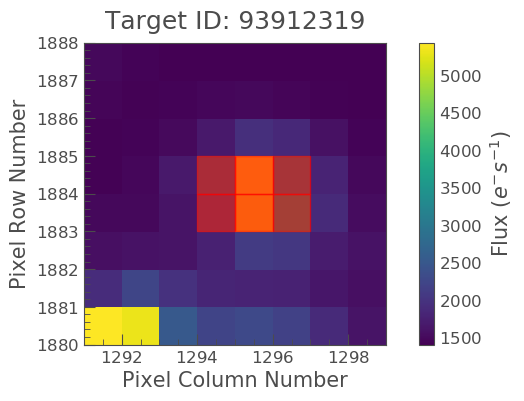

In [21]:
# Open saved LightCurve FITS file, and load the aperture mask
mask_filepath = glob(sample_filename.format(ticids[2], sector))[0]
lcf = TessLightCurveFile(mask_filepath)
current_aperture = lcf.hdu[2].data

# Append current aperture to list of apertures, ONLY if it doesn't exist there already
apertures.append(current_aperture)

# Display current aperture
tpf.plot(aperture_mask=current_aperture, mask_color='red')
current_aperture

### Interpolate between masks

The mask structure:
- Integer mask
- Value of 3 means inside aperture
- Value of 1 means outside aperture

I want to keep the mask pixels that are shared between at least two images. That means that if I sum the three aperture masks, I will keep the mask pixels that are above 6.

In [22]:
boolean_apt = np.sum(apertures, axis=0) > 6.
# new_apt = np.ones(apertures[0].shape, dtype=np.ubyte)
new_apt = np.zeros(apertures[0].shape, dtype=bool)
new_apt[boolean_apt] = True
new_apt

array([[False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False,  True,  True,  True, False, False],
       [False, False, False,  True,  True,  True, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False]])

Now that we have the final aperture mask, we can use it to produce the light curves, and save them!

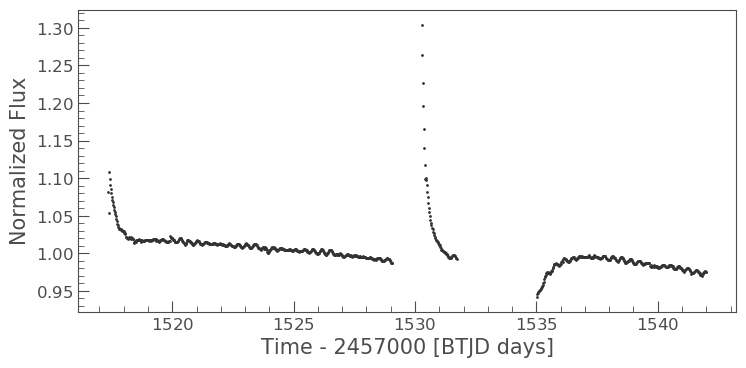

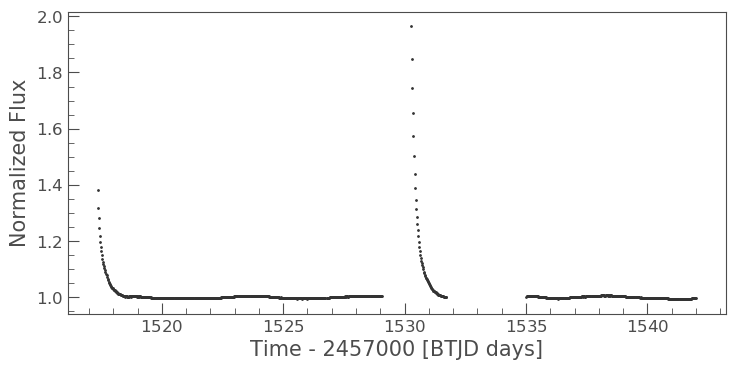

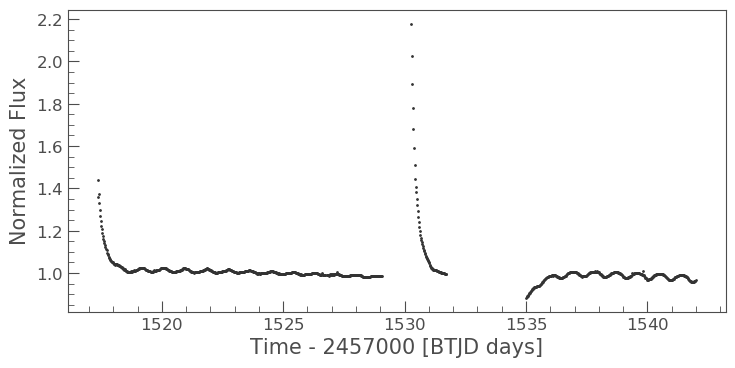

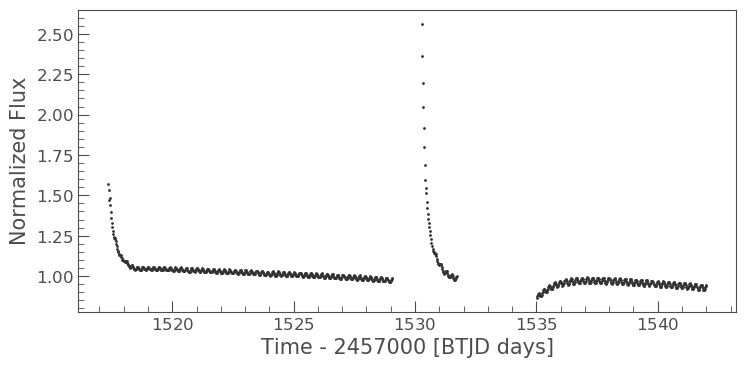

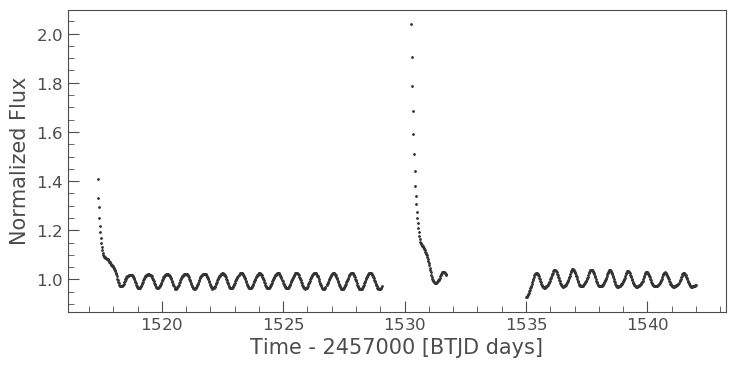

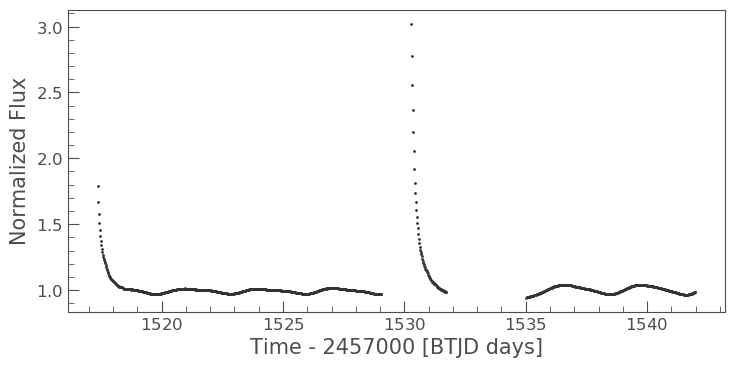

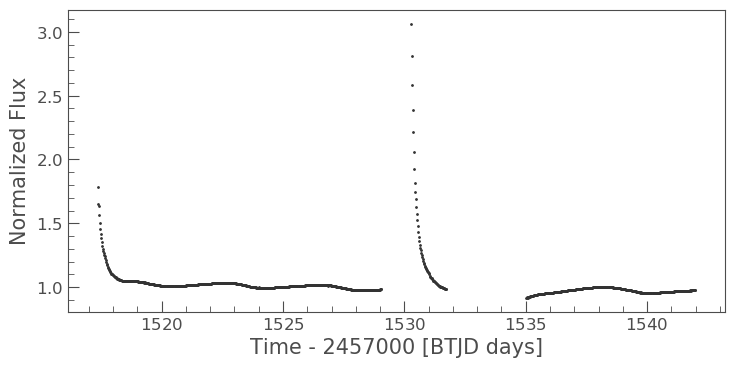

In [23]:
for target in targets[groups == current_group]['TIC ID']:
    # Download cutouts to create light curve
    tpf = search_tesscut(target, sector=sector).download(cutout_size=cutoutsize)
    # Generate light curve using the aperture mask `new_apt`
    lc = tpf.to_lightcurve(aperture_mask=new_apt)
    # Export light curve into FITS file
    lc.to_fits(lc_filename.format(target, sector), overwrite=True)
    # scatter plot light curve
    lc.scatter()
    plt.show()